In [12]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [13]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [14]:
NUM_CLASSES = 2

# 学習データ読み込み

In [15]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [16]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [19]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                860       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 8)                 88        
                                                                 
Total params: 1158 (4.52 KB)
Trainable params: 1158 (4.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [21]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [34]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
10/10 [==============================] - ETA: 0s - loss: 0.4750 - accuracy: 0.8024 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
10/10 [==============================] - 3s 108ms/step - loss: 0.4750 - accuracy: 0.8024 - val_loss: 0.1791 - val_accuracy: 0.9304
Epoch 2/1000
 8/10 [=======================>......] - ETA: 0s - loss: 0.4587 - accuracy: 0.8262

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
10/10 [==============================] - 0s 33ms/step - loss: 0.4510 - accuracy: 0.8290 - val_loss: 0.1739 - val_accuracy: 0.9304
Epoch 3/1000
 8/10 [=======================>......] - ETA: 0s - loss: 0.4956 - accuracy: 0.8115
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
10/10 [==============================] - 0s 30ms/step - loss: 0.5095 - accuracy: 0.8033 - val_loss: 0.1720 - val_accuracy: 0.9304
Epoch 4/1000
 8/10 [=======================>......] - ETA: 0s - loss: 0.4879 - accuracy: 0.8154
Epoch 4: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
10/10 [==============================] - 0s 32ms/step - loss: 0.4840 - accuracy: 0.8187 - val_loss: 0.1715 - val_accuracy: 0.9304
Epoch 5/1000
 1/10 [==>...........................] - ETA: 0s - loss: 0.4744 - accuracy: 0.8281
Epoch 5: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
10/10 [==========

In [35]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

4/4 [==============================] - 0s 7ms/step - loss: 0.1699 - accuracy: 0.9356


In [36]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [37]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 206ms/step
[8.5606545e-05 2.6763441e-06 3.6749688e-03 2.0868594e-03 1.5312995e-01
 1.0655454e-03 5.5240025e-07 8.3995390e-01]
7


# 混同行列

13/13 [==============================] - 0s 3ms/step


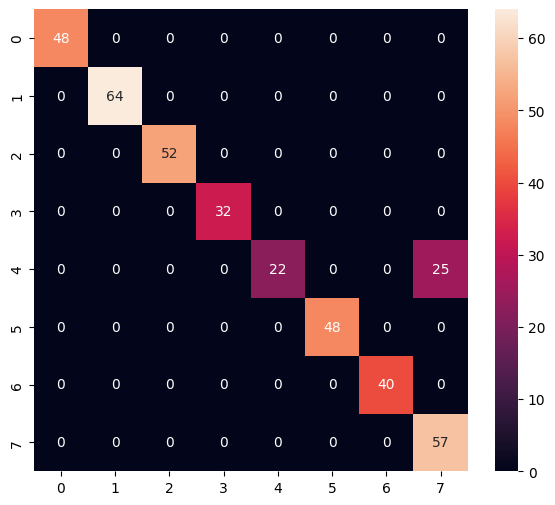

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        64
           2       1.00      1.00      1.00        52
           3       1.00      1.00      1.00        32
           4       1.00      0.47      0.64        47
           5       1.00      1.00      1.00        48
           6       1.00      1.00      1.00        40
           7       0.70      1.00      0.82        57

    accuracy                           0.94       388
   macro avg       0.96      0.93      0.93       388
weighted avg       0.96      0.94      0.93       388



In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [39]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpzn009y1c\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpzn009y1c\assets


6748

# 推論テスト

In [41]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [42]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [43]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [44]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [45]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[8.5606465e-05 2.6763389e-06 3.6749670e-03 2.0868592e-03 1.5312995e-01
 1.0655448e-03 5.5240019e-07 8.3995390e-01]
7
